In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [8]:
# Load data
df = pd.read_csv('training_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nCountries: {df['country'].nunique()}")
print(f"Year range: {df['year'].min():.0f} to {df['year'].max():.0f}")
print(f"Time span: {df['year'].max() - df['year'].min():.0f} years")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (17538, 8)

First few rows:
       country    year    tfr  life_expectancy  net_migrants  pop_growth_rate  \
0  Afghanistan  1950.0  7.248           28.156        6161.0            1.275   
1  Afghanistan  1951.0  7.260           28.584        4903.0            1.360   
2  Afghanistan  1952.0  7.260           29.014         145.0            1.374   
3  Afghanistan  1953.0  7.266           29.452       -8867.0            1.335   
4  Afghanistan  1954.0  7.254           29.698       -6837.0            1.394   

   crude_birth_rate  population  
0            49.380   7776176.0  
1            49.624   7879339.0  
2            49.784   7987783.0  
3            49.979   8096698.0  
4            50.004   8207950.0  

Data types:
country              object
year                float64
tfr                 float64
life_expectancy     float64
net_migrants        float64
pop_growth_rate     float64
crude_birth_rate    float64
population          float64
dtype: object

Countries: 237

In [9]:
# Categorize countries by average life expectancy (proxy for development stage)
country_life_exp = df.groupby('country')['life_expectancy'].mean()

# Demographic transition stages based on life expectancy
df['country_dev_stage'] = df['country'].map(
    lambda x: 'Early' if country_life_exp[x] < 60 
    else 'Transitional' if country_life_exp[x] < 70 
    else 'Advanced'
)

print("Countries by development stage:")
print(df.groupby('country_dev_stage')['country'].nunique())
print("\nSample countries per stage:")
for stage in ['Early', 'Transitional', 'Advanced']:
    countries = df[df['country_dev_stage'] == stage]['country'].unique()[:3]
    print(f"{stage}: {', '.join(countries)}")

Countries by development stage:
country_dev_stage
Advanced        75
Early           73
Transitional    89
Name: country, dtype: int64

Sample countries per stage:
Early: Afghanistan, Algeria, Angola
Transitional: Albania, American Samoa, Anguilla
Advanced: Andorra, Antigua and Barbuda, Argentina


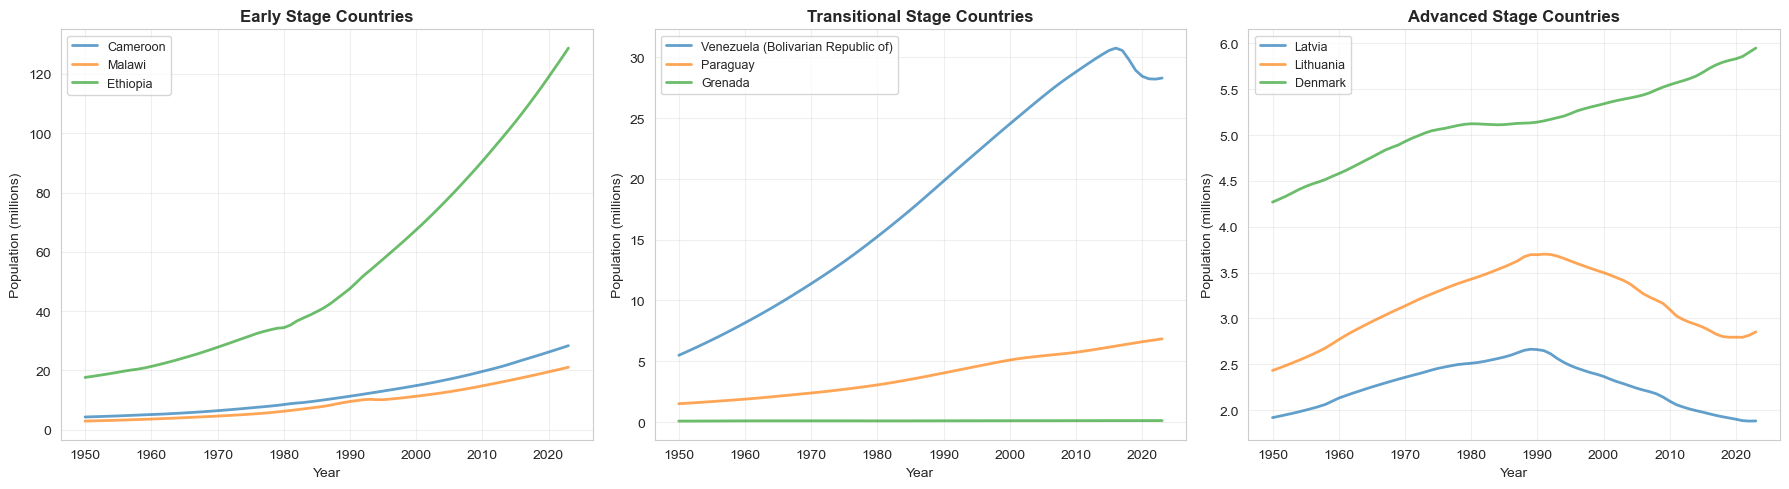

In [10]:
# Plot population trends for representative countries from each stage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stages = ['Early', 'Transitional', 'Advanced']
for idx, stage in enumerate(stages):
    stage_countries = df[df['country_dev_stage'] == stage]['country'].unique()
    sample_countries = np.random.choice(stage_countries, min(3, len(stage_countries)), replace=False)
    
    for country in sample_countries:
        country_data = df[df['country'] == country]
        axes[idx].plot(country_data['year'], country_data['population'] / 1e6, 
                      label=country, alpha=0.7, linewidth=2)
    
    axes[idx].set_title(f'{stage} Stage Countries', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Population (millions)')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

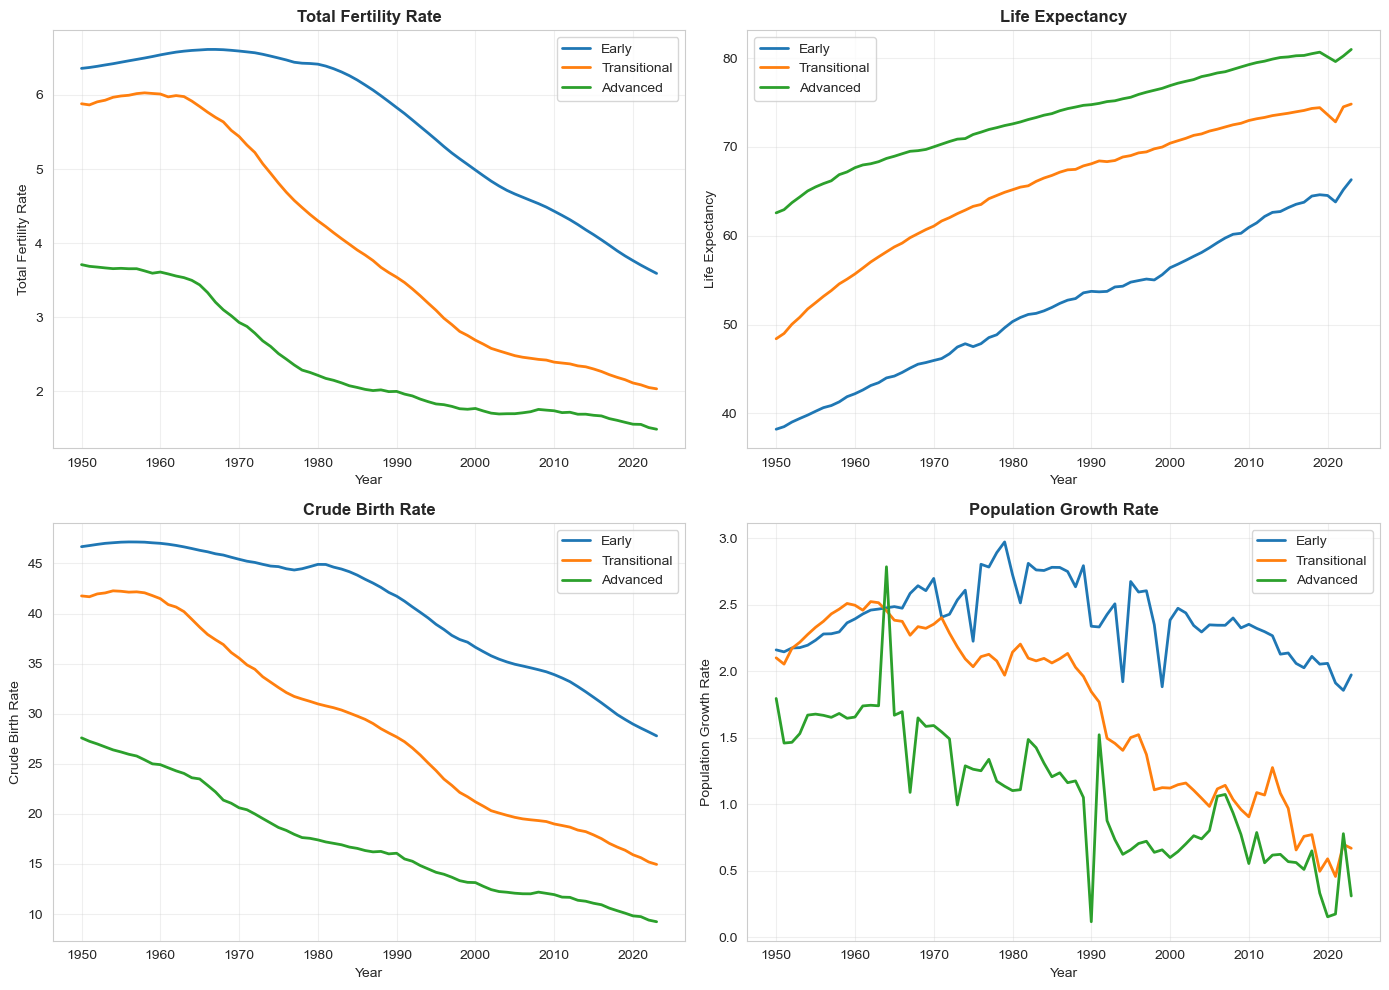

In [11]:
# Examine how demographic indicators vary by development stage
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

indicators = ['tfr', 'life_expectancy', 'crude_birth_rate', 'pop_growth_rate']
titles = ['Total Fertility Rate', 'Life Expectancy', 'Crude Birth Rate', 'Population Growth Rate']

for idx, (indicator, title) in enumerate(zip(indicators, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for stage in ['Early', 'Transitional', 'Advanced']:
        stage_data = df[df['country_dev_stage'] == stage].groupby('year')[indicator].mean()
        ax.plot(stage_data.index, stage_data.values, label=stage, linewidth=2)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Check data completeness for modeling
print("Data Completeness Assessment:")
print(f"Total observations: {len(df)}")
print(f"Complete cases (already cleaned): {len(df)}")

# Countries with sufficient data
countries_sufficient_data = df.groupby('country').size()
print(f"\nCountries with 50+ years of data: {(countries_sufficient_data >= 50).sum()}")
print(f"Median observations per country: {countries_sufficient_data.median():.0f}")
print(f"Min observations per country: {countries_sufficient_data.min():.0f}")
print(f"Max observations per country: {countries_sufficient_data.max():.0f}")

Data Completeness Assessment:
Total observations: 17538
Complete cases (already cleaned): 17538

Countries with 50+ years of data: 237
Median observations per country: 74
Min observations per country: 74
Max observations per country: 74
